## 1. Prepare Data, Network

In [1]:
from sklearn.datasets import fetch_openml
import torch
import numpy as np

mnist = fetch_openml('mnist_784')

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

X_train = torch.tensor(np.array(mnist.data)).float().reshape(-1, 1, 28, 28)[:6000].to(device)
y_train = torch.tensor(np.array(list(map(np.int_, mnist.target))))[:6000].to(device)

X_test = torch.tensor(np.array(mnist.data)).float().reshape(-1, 1, 28, 28)[60000:].to(device)
y_test = torch.tensor(np.array(list(map(np.int_, mnist.target))))[60000:].to(device)

print(X_train.shape) # torch.Size([60000, 1, 28, 28])
print(y_train.shape) # torch.Size([60000])

print(X_test.shape) # torch.Size([10000, 1, 28, 28])
print(y_test.shape) # torch.Size([10000])

/usr/local/lib/python3.8/dist-packages/sklearn/datasets/_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


torch.Size([6000, 1, 28, 28])
torch.Size([6000])
torch.Size([10000, 1, 28, 28])
torch.Size([10000])


In [2]:
def cutout_and_rotate(image):
    image = image.clone().detach() # 얕은 복사 문제 주의(원본 유지)
    x_start = np.random.randint(20) # cut out 시작할 x축 위치(0~19 중 1개)
    y_start = np.random.randint(20) # cut out 시작할 y축 위치(0~19 중 1개)

    image[..., x_start:x_start+9, y_start:y_start+9] = 255 / 2 # 해당 부분 회색 마킹
    return torch.rot90(image, 1, [-2, -1]) # 마지막 두 axis 기준 90도 회전

In [3]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5, stride=1)
        self.fc = nn.Linear(4 * 4 * 20, 100)

    def forward(self, x):
        x = F.relu(self.conv1(x)) # (batch, 1, 28, 28) -> (batch, 10, 24, 24)

        x = F.max_pool2d(x, kernel_size=2, stride=2) # (batch, 10, 24, 24) -> (batch, 10, 12, 12)

        x = F.relu(self.conv2(x)) # (batch, 10, 12, 12) -> (batch, 20, 8, 8)

        x = F.max_pool2d(x, kernel_size=2, stride=2) # (batch, 20, 8, 8) -> (batch, 20, 4, 4)

        x = x.view(-1, 4 * 4 * 20) # (batch, 20, 4, 4) -> (batch, 320)

        x = F.relu(self.fc(x)) # (batch, 320) -> (batch, 100)
        return x # (batch, 100)

In [4]:
class SimCLR_Loss(nn.Module):
    def __init__(self, batch_size, temperature):
        super().__init__()
        self.batch_size = batch_size
        self.temperature = temperature

        self.mask = self.mask_correlated_samples(batch_size)
        self.criterion = nn.CrossEntropyLoss(reduction="sum")
        self.similarity_f = nn.CosineSimilarity(dim=2)

    # loss 분모 부분의 negative sample 간의 내적 합만을 가져오기 위한 마스킹 행렬
    def mask_correlated_samples(self, batch_size):
        N = 2 * batch_size
        mask = torch.ones((N, N), dtype=bool)
        mask = mask.fill_diagonal_(0)
        
        for i in range(batch_size):
            mask[i, batch_size + i] = 0
            mask[batch_size + i, i] = 0
        return mask

    def forward(self, z_i, z_j):

        N = 2 * self.batch_size

        z = torch.cat((z_i, z_j), dim=0)

        sim = self.similarity_f(z.unsqueeze(1), z.unsqueeze(0)) / self.temperature

        # loss 분자 부분의 원본 - augmentation 이미지 간의 내적 합을 가져오기 위한 부분
        sim_i_j = torch.diag(sim, self.batch_size)
        sim_j_i = torch.diag(sim, -self.batch_size)
        
        positive_samples = torch.cat((sim_i_j, sim_j_i), dim=0).reshape(N, 1)
        negative_samples = sim[self.mask].reshape(N, -1)


        labels = torch.from_numpy(np.array([0]*N)).reshape(-1).to(positive_samples.device).long()

        logits = torch.cat((positive_samples, negative_samples), dim=1)
        loss = self.criterion(logits, labels)
        loss /= N
        
        return loss

## 2. Representation Learning

In [5]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

X_train_aug = cutout_and_rotate(X_train) # 각 X_train 데이터에 대하여 augmentation
X_train_aug = X_train_aug.to(device) # 학습을 위하여 GPU에 선언

dataset = TensorDataset(X_train, X_train_aug) # augmentation된 데이터와 pair
batch_size = 100

dataloader = DataLoader(
            dataset,
            batch_size = batch_size)

model = CNN() # 모델 변수 선언
loss_func = SimCLR_Loss(batch_size, temperature = 0.5) # loss 함수 선언

# train 코드 예시
epochs = 10
model.to(device)
model.train()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for i in range(1, epochs + 1):
    total_loss = 0
    for data in tqdm(dataloader):
        origin_vec = model(data[0])
        aug_vec = model(data[1])

        loss = loss_func(origin_vec, aug_vec)
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('Epoch : %d, Avg Loss : %.4f'%(i, total_loss / len(dataloader)))

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch : 1, Avg Loss : 5.0641


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch : 2, Avg Loss : 4.4673


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch : 3, Avg Loss : 4.2546


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch : 4, Avg Loss : 4.1615


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch : 5, Avg Loss : 4.1046


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch : 6, Avg Loss : 4.0618


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch : 7, Avg Loss : 4.0375


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch : 8, Avg Loss : 4.0179


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch : 9, Avg Loss : 3.9973


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch : 10, Avg Loss : 3.9855


## 3. Classification

### 1) Prepare dataset

In [6]:
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
from tqdm import tqdm
from torchvision import datasets, transforms

major_class_num = 420
minor_class_num = 180
# Define the transformations: Convert images to tensor & normalize
MNIST_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalizing with mean=0.5 and std=0.5 for MNIST
])
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=MNIST_transform)

major_classes = [0, 1, 2] # Define major classes
minor_classes = [3, 4, 5, 6, 7, 8, 9] # Define minor classes

images = []
targets = []

# Select samples from major classes
for i in major_classes:
    class_indices = np.where(np.array(trainset.targets) == i)[0]
    selected_indices = class_indices[:major_class_num]

    for idx in selected_indices:
        images.append(trainset[idx][0])
        targets.append(0) # New label: 0 for major

# Select samples from minor classes
for i in minor_classes:
    class_indices = np.where(np.array(trainset.targets) == i)[0]
    selected_indices = class_indices[:minor_class_num]

    for idx in selected_indices:
        images.append(trainset[idx][0])
        targets.append(1) # New label: 1 for minor

# Convert to PyTorch tensors
images = torch.stack(images)
targets = torch.tensor(targets, dtype=torch.long)

# Create a TensorDataset with the selected instances and modified labels
subset = TensorDataset(images, targets)
class_dataloader = DataLoader(subset, batch_size=64, shuffle=True)


### 2) Train Classifier


In [7]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [10]:
class CNN_classifier(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.CNN = model
        self.mlp = nn.Linear(100, 2) # Only two classes: major and minor

    def forward(self, x):
        x = self.CNN(x)
        x = self.mlp(x)
        return x


classifier = CNN_classifier(model).to(device)
classifier_loss = nn.CrossEntropyLoss()
epochs = 10
classifier.train()
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-4)

for i in range(1, epochs + 1):
    correct = 0
    for data, labels in tqdm(class_dataloader):
        data, labels = data.to(device), labels.to(device)
        # print(labels.min(), labels.max()) # Should print 0 and 1
        logits = classifier(data)
        loss = classifier_loss(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        correct += torch.sum(torch.argmax(logits, 1) == labels).item()

    print('Epoch : %d, Train Accuracy : %.2f%%' % (i, correct * 100 / len(subset)))

100%|██████████| 40/40 [00:00<00:00, 296.28it/s]


Epoch : 1, Train Accuracy : 56.90%


100%|██████████| 40/40 [00:00<00:00, 312.73it/s]


Epoch : 2, Train Accuracy : 91.23%


100%|██████████| 40/40 [00:00<00:00, 317.54it/s]


Epoch : 3, Train Accuracy : 93.57%


100%|██████████| 40/40 [00:00<00:00, 319.52it/s]


Epoch : 4, Train Accuracy : 94.01%


100%|██████████| 40/40 [00:00<00:00, 319.76it/s]


Epoch : 5, Train Accuracy : 93.93%


100%|██████████| 40/40 [00:00<00:00, 302.18it/s]


Epoch : 6, Train Accuracy : 94.17%


100%|██████████| 40/40 [00:00<00:00, 317.62it/s]


Epoch : 7, Train Accuracy : 94.13%


100%|██████████| 40/40 [00:00<00:00, 331.91it/s]


Epoch : 8, Train Accuracy : 94.17%


100%|██████████| 40/40 [00:00<00:00, 330.67it/s]


Epoch : 9, Train Accuracy : 94.40%


100%|██████████| 40/40 [00:00<00:00, 320.55it/s]

Epoch : 10, Train Accuracy : 94.84%


### 2) Test Classification model

In [12]:
testset = datasets.MNIST(root='./data', train=False, download=True, transform=MNIST_transform)

# Prepare the custom test dataset
test_major_class_num = 180 # You can set appropriate numbers
test_minor_class_num = 60
test_images = []
test_targets = []

for i in range(10):
    class_indices = np.where(np.array(testset.targets) == i)[0]
    num_samples = test_major_class_num if i < 3 else test_minor_class_num
    selected_indices = class_indices[:num_samples]

    for idx in selected_indices:
        test_images.append(testset[idx][0])
        test_targets.append(0 if i < 3 else 1) # New labels: 0 for major, 1 for minor

# Convert to PyTorch tensors
test_images = torch.stack(test_images)
test_targets = torch.tensor(test_targets, dtype=torch.long)

# Create a TensorDataset with the selected instances and modified labels
test_subset = TensorDataset(test_images, test_targets)
test_dataloader = DataLoader(test_subset, batch_size=64, shuffle=False)

# Evaluate the classifier
classifier.eval() # Set to evaluation mode
correct = 0
with torch.no_grad():
    for data, labels in tqdm(test_dataloader):
        data, labels = data.to(device), labels.to(device)
        logits = classifier(data)
        correct += torch.sum(torch.argmax(logits, 1) == labels).item()

print('Test Accuracy : %.2f%%' % (correct * 100 / len(test_subset)))


100%|██████████| 15/15 [00:00<00:00, 736.58it/s]

Test Accuracy : 95.62%


100%|██████████| 63/63 [00:00<00:00, 1355.83it/s]

Test Accuracy : 93.40%


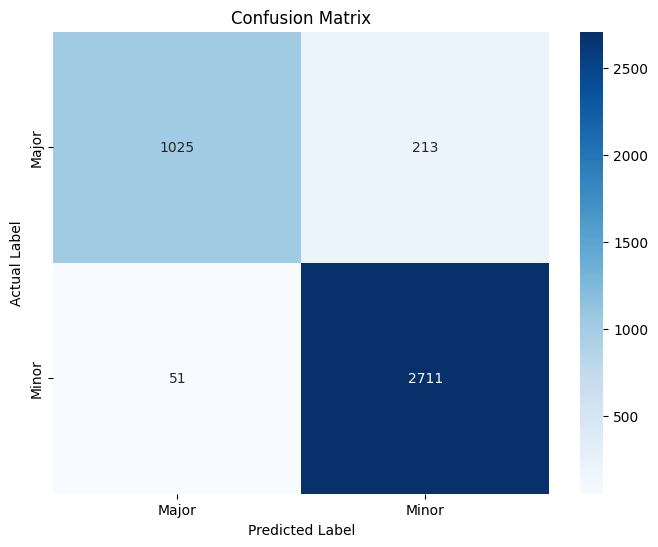

In [18]:
# Load the MNIST test set
testset = MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

# Prepare the custom test dataset with 4000 instances
test_images = []
test_targets = []

for i, (image, target) in enumerate(testset):
    if len(test_images) >= 4000:
        break
    label = 0 if target < 3 else 1  # New labels: 0 for major, 1 for minor
    test_images.append(image)
    test_targets.append(label)

# Convert to PyTorch tensors
test_images = torch.stack(test_images)
test_targets = torch.tensor(test_targets, dtype=torch.long)

# Create a TensorDataset with the selected test instances and labels
test_subset = TensorDataset(test_images, test_targets)
test_dataloader = DataLoader(test_subset, batch_size=64, shuffle=False)

# Testing the model
classifier.eval()  # Set the model to evaluation mode
correct = 0
predicted_labels = []
true_labels = []

with torch.no_grad():
    for data, labels in tqdm(test_dataloader):
        data, labels = data.to(device), labels.to(device)
        logits = classifier(data)
        preds = torch.argmax(logits, 1)
        correct += torch.sum(preds == labels).item()

        # Store predicted and true labels
        predicted_labels.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

print('Test Accuracy : %.2f%%' % (correct * 100 / len(test_subset)))

# Create the confusion matrix
confusion = np.zeros((2, 2), dtype=int)
for true, pred in zip(true_labels, predicted_labels):
    confusion[true][pred] += 1

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=['Major', 'Minor'], yticklabels=['Major', 'Minor'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()